# Mirror-based Extrinsic Camera Calibration

## Goal

The goal of this notebook is to calibrate the extrinsic parameter of a camera w.r.t. a reference object (e.g., chessboard) that is not directly visible from the camera.  The key idea is to capture the reference object through a mirror.  As described in the papers below, we can calibrate the camera and the mirror poses w.r.t. the reference object using 3 or more images taken with different mirror poses.

- [Kosuke Takahashi, Shohei Nobuhara, and Takashi Matsuyama, “Mirror-based Camera Pose Estimation Using an Orthogonality Constraint,” IPSJ Transactions on Computer Vision and Applications, vol. 8, pp. 11–19, Feb. 2016.](https://github.com/computer-vision/takahashi2012cvpr)
- [Kosuke Takahashi, Shohei Nobuhara, and Takashi Matsuyama, “A new mirror-based extrinsic camera calibration using an orthogonality constraint,” in Proc. of IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2012, pp. 1051–1058.](https://github.com/computer-vision/takahashi2012cvpr)

This technique can be used for calibrating a webcam-display system, non-overlapping cameras, and so forth.

## Outline

Consider a static 3D reference object with $N_p$ feature points ${p'}^{i} \; (i=1,\dots,N_p)$ in the scene, such as a chess patten shown in a flat display.  By observing the 3D reference object through a planar mirror $\pi_j \; (j=1,\dots,N_m)$ at $N_m$ different poses, the 3D reference object is mirrored as $p_j^i$ and is projected to $q_j^i$ in the camera image.

Given the 3D coordinates of $N_p$ feature points ${p'}^{i}$ in the model (= world) coordinate system and their projections $q_j^i$ in the $N_m$ images, we can calibrate

- the 3D pose $R$, $t$ of the camera, and
- the 3D normal $n_j$ and the distance $d_j$ of each mirror,

in the model coordinate system, i.e., w.r.t. the reference object.  In this calibration, the following assumptions should be met.

- The intrinsic parameter $K$ is given a priori.
- The 2D positions $p_j^i$ are given in the undistorted image coordinate.
- $N_p \ge 3$ (larger is better)
- $N_m \ge 3$ (larger is better)
- The mirror does not have a transparent layer on it, i.e., it is a [first-surface mirror](https://en.wikipedia.org/wiki/First-surface_mirror) without refraction.
- The mirror poses are _mutually independent_.  They are not parallel and do not intersect at a single axis.

In practice, it is strongly recommended to use a ChAruCo pattern as the reference object since we can easilly identify if the pattern is flipped (mirrored) or not.


## Procedure

A typical procedure is as follows.

1. Prepare images as `INPUT_FILES`.
   1. Show a ChAruCo pattern on a flat panel display.
      - The following cell generates a pattern image of `DISPLAY_WIDTH` by `DISPLAY_HEIGHT` px and saves it as `OUT_PATTERN`.  Modify these parameters according to your display, and show it in the fullscreen mode.
   2. Capture the ChAruCo pattern through a front-surface mirror.
      - Capture at least with 3 different mirror poses (change the orientation of the mirror as well as its position **as much as possible**).
      - Save them as `INPUT_FILES`.
2. Update the intrinsic parameter `cameraMatrix`.
   - The intrinsic parameter should be calibrated beforehand.
3. Double-check `unmirror_image()` and `unmirror_points()` are consistent with your capture scenario.
   - The ChAruCo pattern detector ignores patterns captured through a mirror since it is flipped and is not valid as AruCo markers.
   - `unmirror_image()` flips the ChAruCo pattern in captured image back to the original appearance, and allow the ChAruCo pattern detector find the chess corners.  `unmirror_points()` then flips the detected chess corner positions back to the original positions in the captured image.
   - By default, these two functions flips left and right.


## ChAruCo pattern

This cell generates a ChAruCo pattern for your display, and saves it as `OUT_PATTERN`.

It is strongly recommended to specify the exact resolution of your display in `DISPLAY_WIDTH` and `DISPLAY_HEIGHT`, and show the generated image in the fullscreen mode without any scaling.

The cell also outputs the chess corner posisions in the pattern, and shows their detection order in the original pattern and its mirrored pattern.

Chess corners (x, y, z)
[[ 213.  226.    0.]
 [ 427.  226.    0.]
 [ 640.  226.    0.]
 [ 853.  226.    0.]
 [1067.  226.    0.]
 [1280.  226.    0.]
 [1493.  226.    0.]
 [1707.  226.    0.]
 [1920.  226.    0.]
 [2133.  226.    0.]
 [2347.  226.    0.]
 [2560.  226.    0.]
 [2773.  226.    0.]
 [2987.  226.    0.]
 [3200.  226.    0.]
 [3413.  226.    0.]
 [3627.  226.    0.]
 [ 213.  440.    0.]
 [ 427.  440.    0.]
 [ 640.  440.    0.]
 [ 853.  440.    0.]
 [1067.  440.    0.]
 [1280.  440.    0.]
 [1493.  440.    0.]
 [1707.  440.    0.]
 [1920.  440.    0.]
 [2133.  440.    0.]
 [2347.  440.    0.]
 [2560.  440.    0.]
 [2773.  440.    0.]
 [2987.  440.    0.]
 [3200.  440.    0.]
 [3413.  440.    0.]
 [3627.  440.    0.]
 [ 213.  653.    0.]
 [ 427.  653.    0.]
 [ 640.  653.    0.]
 [ 853.  653.    0.]
 [1067.  653.    0.]
 [1280.  653.    0.]
 [1493.  653.    0.]
 [1707.  653.    0.]
 [1920.  653.    0.]
 [2133.  653.    0.]
 [2347.  653.    0.]
 [2560.  653.    0.]
 [2773.  6

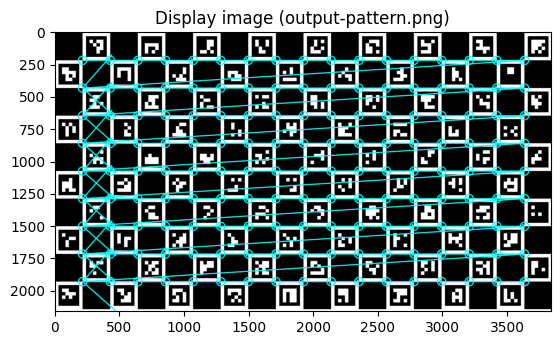

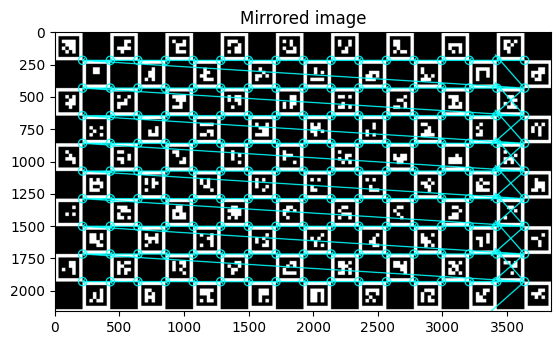

In [1]:
import sys, os, cv2
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pycalib


# Chessboard configuration

DISPLAY_WIDTH = 3840
DISPLAY_HEIGHT = 2160
BOARD_COLS = 18
BOARD_ROWS = 10
OUT_PATTERN = 'output-pattern.png'
Np = (BOARD_COLS-1) * (BOARD_ROWS-1)

aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_250)
board = cv2.aruco.CharucoBoard((BOARD_COLS, BOARD_ROWS), 0.02, 0.015, aruco_dict)

parameters =  cv2.aruco.DetectorParameters()
parameters.cornerRefinementMethod = cv2.aruco.CORNER_REFINE_CONTOUR
detector = cv2.aruco.CharucoDetector(board, detectorParams=parameters)

# check if the board is correct
image = board.generateImage((DISPLAY_WIDTH, DISPLAY_HEIGHT))
cv2.imwrite(OUT_PATTERN, image)

# Input images capturing the chessboard above
INPUT_FILES = '../data/mirror/frame_*.jpg'

cameraMatrix, distCoeffs, _, _, _ = pycalib.util.load_calib('../data/mirror/GP12_5K_Linear.json')
cameraMatrix = cameraMatrix[0]
distCoeffs = distCoeffs[0]

# unmirror the captured image
def unmirror_image(img):
    return cv2.flip(img, 1)  # flip left-right

# pts: Nx1x2
def unmirror_points(sz, pts):
    q = pts.copy()
    q[:,0,0] = sz[1] - q[:,0,0] # flip left-right
    return q

def label_id(img, pts, *, radius=32, thickness=8):
    pts = pts.reshape((-1, pts.shape[-1]))

    img = img.copy()
    if len(img.shape) == 2 or img.shape[2] == 1:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    for p in pts:
        cv2.circle(img, (int(p[0]), int(p[1])), radius, (0,255,255), thickness)

    for p, q in zip(pts, pts[1:]):
        cv2.arrowedLine(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), (0,255,255), thickness)
    return img

# Detect the corners in the display image
c_corners, c_ids, corners, ids = detector.detectBoard(image)
objPoints, imgPoints = board.matchImagePoints(c_corners, c_ids)

OBJ_PTS = np.rint(imgPoints).reshape((-1, 2))
assert OBJ_PTS.shape == ((BOARD_COLS-1) * (BOARD_ROWS-1), 2)

OBJ_PTS = np.concatenate([OBJ_PTS, np.zeros((len(OBJ_PTS), 1))], axis=1)
print('Chess corners (x, y, z)')
print(OBJ_PTS)



# Display shows this pattern
plt.figure()
plt.imshow(label_id(image, OBJ_PTS))
plt.title(f'Display image ({OUT_PATTERN})')
#plt.axis('off')
plt.show()

# Camera captures this pattern (via mirror)
plt.figure()
plt.imshow(label_id(unmirror_image(image), unmirror_points(image.shape, OBJ_PTS[:,None,:])), cmap='gray')
plt.title('Mirrored image')
#plt.axis('off')
plt.show()

#print(objPoints, imgPoints, OBJ_PTS_PX)



## 2D corner detection

This cell detects ChAruCo corners from images specified in `INPUT_FILES`.  Make sure that each image captures the pattern as shown in the "Mirrored image" above.

- It is OK to have some corners missing (not detected) in some frames.  The algorithm utilizes images with at least 3 corners.

#0 ../data/mirror/frame_00.jpg  found 64 corners.
#1 ../data/mirror/frame_01.jpg  found 52 corners.
#2 ../data/mirror/frame_02.jpg  found 41 corners.
#3 ../data/mirror/frame_03.jpg  found 37 corners.
#4 ../data/mirror/frame_04.jpg  found 48 corners.
#5 ../data/mirror/frame_05.jpg  found 45 corners.
#6 ../data/mirror/frame_06.jpg  found 39 corners.
#7 ../data/mirror/frame_07.jpg  found 43 corners.
#8 ../data/mirror/frame_08.jpg  found 34 corners.
#9 ../data/mirror/frame_09.jpg  found 43 corners.
#10 ../data/mirror/frame_10.jpg  found 33 corners.
#11 ../data/mirror/frame_11.jpg  found 58 corners.


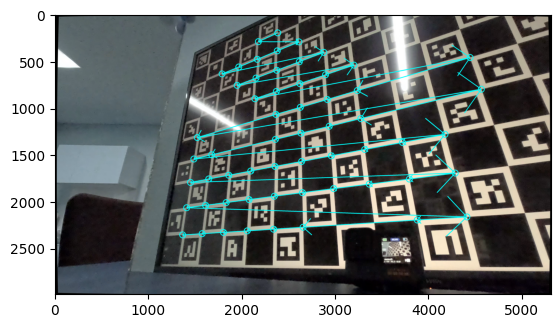

In [2]:
IMG_PTS = []
img_pts_nan = np.full((Np,2), np.nan)

for idx, i in enumerate(sorted(glob(INPUT_FILES))):
    frame = cv2.imread(i, cv2.IMREAD_COLOR)
    frame = cv2.undistort(frame, cameraMatrix, distCoeffs)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = unmirror_image(gray) # mirror
    c_corners, c_ids, corners, ids = detector.detectBoard(gray)
    ret = len(c_corners) if c_corners is not None else 0
    print(f'#{idx} {i}  found {ret} corners.')
    if ret >= 3:
        objPoints, imgPoints = board.matchImagePoints(c_corners, c_ids)
        imgPoints = unmirror_points(gray.shape, imgPoints)
        p = img_pts_nan.copy()
        p[c_ids, :] = imgPoints
        IMG_PTS.append(p)
    else:
        print(f'#{idx} {i}  too few points, ignored.')

    imsize = (gray.shape[1], gray.shape[0])

IMG_PTS = np.array(IMG_PTS)

# show sample image
plt.figure()
plt.imshow(label_id(frame, imgPoints))
plt.show()

## Calibration

This cell calibrates the camera and the mirror poses w.r.t. the ChAruCo pattern on the display.  It first computes a linear solution, and then fine-tune it to minimize the reprojection error.

In [3]:
print('Camera Matrix', cameraMatrix)
print('Object Points (Np x 3) = ', OBJ_PTS.shape)
print('Image Points (Nm x Np x 2) = ', IMG_PTS.shape)
print(f'{np.sum(np.isnan(IMG_PTS[:,:,0]))} out of {len(IMG_PTS.reshape((-1,2)))} points are masked out')

R0, T0, n0, d0, rep0 = pycalib.mirror.tnm(OBJ_PTS, IMG_PTS, cameraMatrix)
print(f'Reprojection error (linear) = {rep0:.3} px')

R, T, n, d, rep = pycalib.mirror.tnm_ba(OBJ_PTS, IMG_PTS, cameraMatrix, R0, T0, n0, d0)
print(f'Reprojection error (BA) = {rep:.3} px')



Camera Matrix [[2.54761879e+03 0.00000000e+00 2.66287666e+03]
 [0.00000000e+00 2.54761879e+03 1.48628081e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Object Points (Np x 3) =  (153, 3)
Image Points (Nm x Np x 2) =  (12, 153, 2)
1299 out of 1836 points are masked out
Reprojection error (linear) = 24.6 px
Reprojection error (BA) = 2.5 px


## Visualization

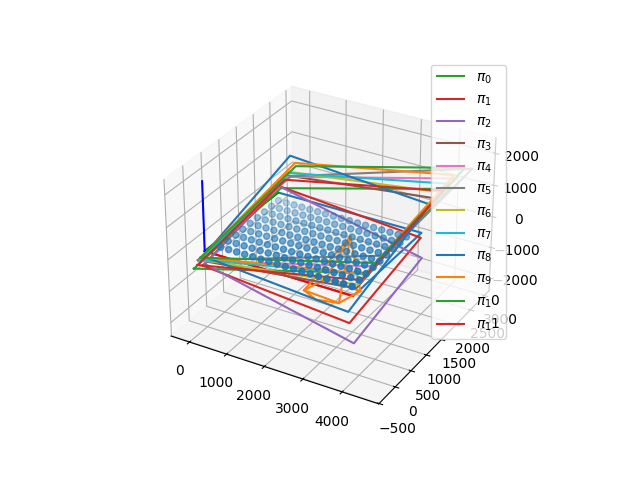

In [4]:
%matplotlib widget

display = np.array( [ [0, 0, 0],
                      [DISPLAY_WIDTH, 0, 0],
                      [DISPLAY_WIDTH, DISPLAY_HEIGHT, 0],
                      [0, DISPLAY_HEIGHT, 0],
                      [0, 0, 0] ] )


fig = plt.figure()
ax = plt.axes(projection='3d')
fig.add_axes(ax)

# Display
ax.scatter(OBJ_PTS[:,0], OBJ_PTS[:,1], OBJ_PTS[:,2])
ax.plot(display[:,0], display[:,1], display[:,2])

# World coordinate system
ax.plot([0, DISPLAY_WIDTH], [0, 0], [0, 0], color='red')    # X
ax.plot([0, 0], [0, DISPLAY_HEIGHT], [0, 0], color='green') # Y
ax.plot([0, 0], [0, 0], [0, DISPLAY_HEIGHT], color='blue')  # Z

# Camera
pycalib.plot.plotCamera(ax, R.T, -R.T@T, scale=DISPLAY_WIDTH//8)

# Mirror
for i, (ni, di) in enumerate(zip(n, d)):
    pycalib.plot.plotMirror(ax, display, ni, di, rf'$\pi_{i}$')

plt.legend()
plt.show()